# Biophysics Problem Set 1 -- Poisson Statistics and Chemotaxis

## Name: William Cerny
## Due Date: 4/21/20

In [1]:
## necessary packages
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import animation
import scipy
from scipy.interpolate import interp1d
from matplotlib.colors import Normalize, LogNorm


## Not strictly necessary for this assignment but used for animations at the end!
from celluloid import Camera 
from IPython.display import HTML

# Question 1

## 1a)

Define a very straightforward function to generate random numbers between 0 and 1.

In [2]:
def genRandomNumbers(n):
    return np.random.uniform(0,1,n)

## 1b)

Generate random numbers between 0 and 1, count how many are below a threshold value of k, and store that value in an array called 'results'. Do this many times in order to get robust statistics.

In [3]:
def countSubpoints(num_iter,threshold_k, n):
    results  = []
    for i in range(1,num_iter):
        set = genRandomNumbers(n)
        below_threshold = np.where(set < threshold_k)
        num_below_threshold_N = len(below_threshold[0])
        results.append(num_below_threshold_N)
    return results

Report the mean and variance of the results above for the test case of k = .025:

In [4]:
arr = countSubpoints(num_iter = 1000, threshold_k = .025, n = 1000)
variance = np.var(arr)
mean = np.mean(arr)
print('The mean is %f and the variance is %f'%(mean,variance))

The mean is 25.066066 and the variance is 25.635275


They are approximately equal, which is what would be expected for small k and large n.

## 1c)

Here, I try a range of values ranging from k = .001 to k = .1 to see what the relationship between mean and variance is.

In [5]:
master_means_array = []
master_variance_array = []


for k in np.linspace(.001,.1,50):

    arr = countSubpoints(num_iter = 10000, threshold_k = k, n = 100)
    master_means_array.append(np.mean(arr))
    master_variance_array.append(np.var(arr))

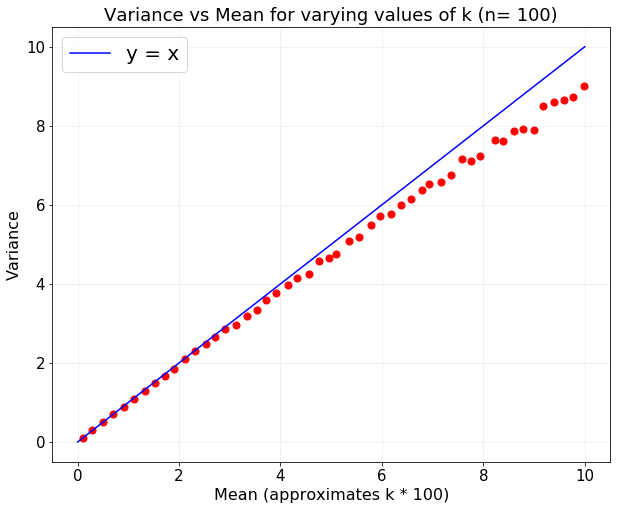

In [6]:
plt.figure(figsize = (10,8))

plt.scatter(master_means_array, master_variance_array, s= 50, color =  'red')
plt.title('Variance vs Mean for varying values of k (n= 100)', fontsize = 18)
plt.xlabel('Mean (approximates k * 100)', fontsize = 16)
plt.ylabel('Variance', fontsize = 16)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid(alpha = .2)
x=  np.linspace(0,10,100)
plt.plot(x,x, color = 'blue', label = 'y = x')
plt.legend(fontsize = 20)

For a Poisson process, one would expect that the mean is equal to the variance. The above plot shows that this is mostly the case for the "low k" regime, but still quite imperfect.

The reason why this result is Poisson at all is because the true underlying distribution is binomial: either the number is within the threshold k, or not, and k determines the probability of each of those two outcomes (a "Bernoulli trial"). Binomial distributions excellently approximate Poisson distributions in the limit of very large n and very small p. Another way of saying this is that binomial distributions converge to Poisson distribs. as n grows toward infinity and p tends to 0. 

For reference, a statistics book I have open suggests that binomial distributions converge to Poisson distributions if the condition n >= 100 and np<10 (where p here is k). This is consistent with the result I have shown above: in the regime where k (and therefore p) is less than .1, the result for n=100 (and thus np <= 10) shows a linear relationship / Poisson process.

## 1d)

Here, I use the same code as above but now using a much wider range of k values.

In [7]:
master_means_array = []
master_variance_array = []


for k in np.linspace(.01,1,50):

    arr = countSubpoints(num_iter = 10000, threshold_k = k, n = 100)
    master_means_array.append(np.mean(arr))
    master_variance_array.append(np.var(arr))

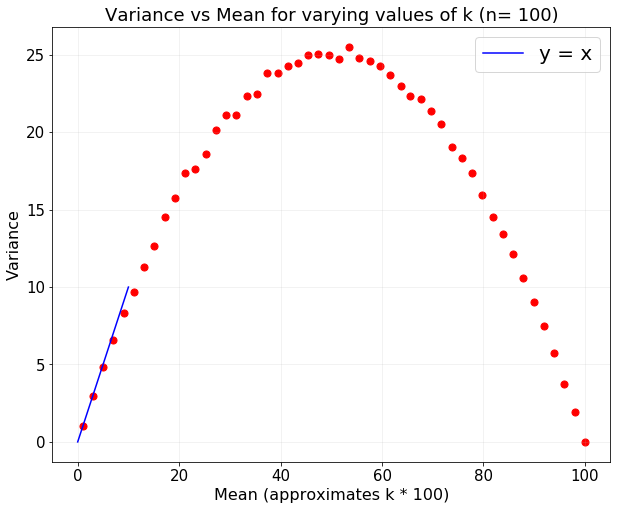

In [8]:
plt.figure(figsize = (10,8))

plt.scatter(master_means_array, master_variance_array, s= 50, color =  'red')
plt.title('Variance vs Mean for varying values of k (n= 100)', fontsize = 18)
plt.xlabel('Mean (approximates k * 100)', fontsize = 16)
plt.ylabel('Variance', fontsize = 16)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid(alpha = .2)
x=  np.linspace(0,10,100)
plt.plot(x,x, color = 'blue', label = 'y = x')
plt.legend(fontsize = 20)

This plot shows that that the interpretation of binomial distribution as a Poisson distribution breaks down for larger values of k (eg nk > 10 for n=100), as evidenced by the fact that instead of showing the linear relationship that mean = variance across all values of k, the relationship curves downward.

The most important reason why this happens can be explained by the limiting case of k =1. In the k = 1 case, the probability that a random number drawn from [0,1] is less than the threshold of 1 is exactly 100 %. In other words, no matter how many trials are conducted, you will pick a number below k every time. This intuitively means that the variance is 0, since the number of numbers less than k quite literally does not vary at all -- it is always every sample. 

Since k = 1 necessitates that variance is 0, it is quite clear that there cannot be a Poisson process past some limiting value of k, since the variance must not be monotonic (it must go up, as seen in the low k regime, and then return to 0). One can easily claim then that this curve would turn over at a probability of .5 (aka k =.5). As k grows greater than .5, the likelihood of numbers greater than k gets smaller and smaller, and it becomes quite rare to get them at all, so in many cases, there is little variation in the number of numbers greater than k between trials -- hence lower variance in the number below k.


# Question 2 (Simulation Track)

2a is not a question.

## 2b) i.

I wanted to create a bit of an exotic function for fun, so I generate some points that follow a two-peaked pattern defined by a function of form x* sin(x). I then use a cubic spline to interpolate a handful of training points following that function. The reason why using a spline is nice is because it stores all information about the concentration gradient, so I simply call spline(x) to get concentration and dC/dx at a given location rather than doing the actual calculation of x* sin(x) and its derivative for each single potential point the bacterium could move to. 

In [9]:
x = np.linspace(0,9.4,10000)
y = .7 *x * np.sin(x) + 4


##  I use a spline here because it allows for convenient derivative calculation
spl = scipy.interpolate.UnivariateSpline(x, y, k=3, s=0)
xnew = np.linspace(0, 9.4, 20000, endpoint=True)
ynew = spl(xnew)

## define the maximum positive gradient the bacterium could experience. This is 
## used to scale the length of each run between L_run and 3*L_run.
deriv = spl.derivative()
deriv_array = deriv(xnew)
positive_derivative_regime = deriv_array[deriv_array > 0]
maxgrad = np.max(positive_derivative_regime) 

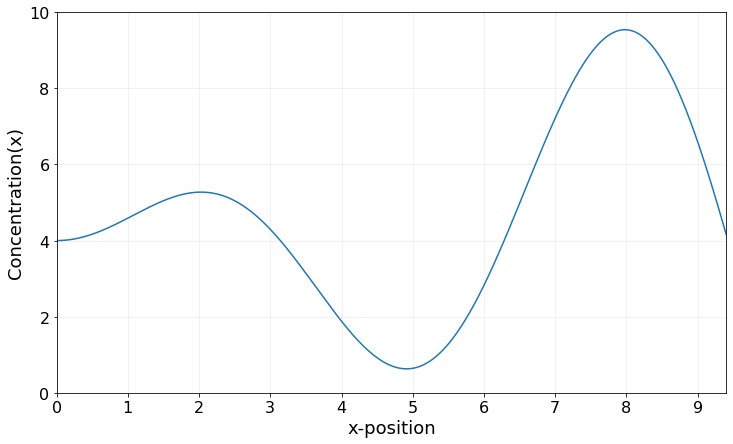

In [10]:
plt.figure(figsize = (12,7))
plt.plot(xnew,ynew)
plt.xlim(0,9.4)
plt.ylim(0,10.)
plt.xlabel('x-position',fontsize = 18)
plt.ylabel('Concentration(x)', fontsize = 18)
plt.xticks(np.arange(10),fontsize = 16)
plt.yticks(fontsize = 16)
plt.grid(alpha= .2)

### Takea brief look at the magnitude of the derivatives:

Text(0, 0.5, 'Proportion')

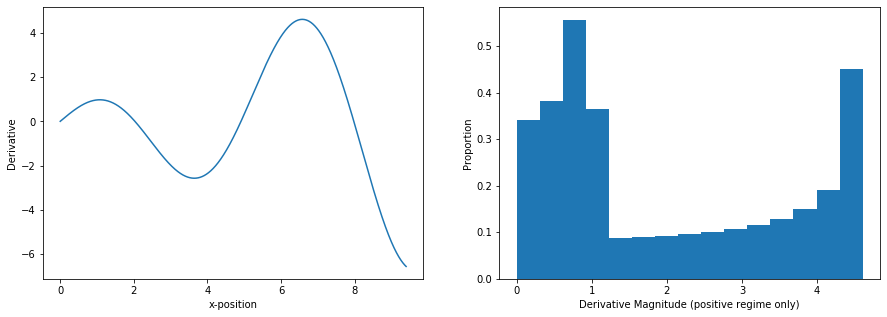

In [11]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(xnew, deriv_array)
plt.xlabel('x-position')
plt.ylabel('Derivative')
plt.subplot(1,2,2)
H = plt.hist(positive_derivative_regime, bins = 15, density = True)
plt.xlabel('Derivative Magnitude (positive regime only)')
plt.ylabel('Proportion')

I later use the magnitude of the positive derivatives to scale between L and 3L.

## 2b) ii. - 2b) iii.

Here, I adopt an object-oriented approach for simulating the bacteria. I create a Python class (object) ecoli which possesses two main attributes (length and position) and multiple functions which guide its movement. I document each of these functions below.

In [12]:
class ecoli: 
    
    def __init__(self, x0, length):
        '''
        Initialize the E coli given the two key properties length (length) and starting position (x0).
        '''
        self.position = x0
        self.L_run = length
        
        
    def get_random_Direction(self):
        '''
        A method which randomly decides whether the ecoli will move to the right or to the left.
        '''
        random_number = np.random.uniform(0,1)
            
        if random_number < .5: ## move left
            return -1 
        else: 
            return  1 ## move right      
        
        
    def getGradient(self, directionscalar):
        '''
        Finds the spatial gradient in "front" of the E coli. 
        The direction considered "Front" is determined by the above method get_random_Direction.
        '''
        if directionscalar ==1: 
            plus = spl(self.position + self.L_run)  ## sense gradient to the right 
            minus = spl(self.position)
            gradient = (plus - minus) / (self.L_run) 
            
        elif directionscalar == -1:
            plus = spl(self.position - self.L_run) ## sense gradient to the left
            minus = spl(self.position)
            gradient = (plus - minus) / (self.L_run)
        
        return gradient
    
    def calcStepLength(self, grad): 
        '''
        Calculate the step length in range [L_run, 3L_run] based on the gradient identified by getGradient().
        See the following cell for explanation of the mapping function I use.
        '''
  
        if grad >0: 
            fracmax = grad / maxgrad ## what fraction of max gradient -- will between 0 and 1 
            length = fracmax * (3 * self.L_run - self.L_run) + self.L_run ## scale to be between L and 3L 
        else:
            length = self.L_run
        return length

        
    def takeStep(self):
        '''
        Combines the previous methods in order to actually move the E.coli object.
        Implements periodic boundaries in case motion moves outside of the range [0,.9.4] which I chose
        since it provides two natural peaks.
        '''
        self.direc = self.get_random_Direction()
        self.grad = self.getGradient(directionscalar = self.direc)
        self.run_length = self.calcStepLength(self.grad) 
        self.oldposition = self.position

        ### Moving right
        if self.direc == 1: 
            vector = np.abs(self.run_length)
            if (self.position + vector <= 9.4) & (self.position + vector >= 0): 
                self.position = self.position + vector
            elif (self.position + vector > 9.4):
                self.position = self.position + vector - 9.4
            else: 
                self.position = (self.position + vector) + 9.4 # normal case: not at boundary
         
        ### Moving left 
        if self.direc == -1: 
            vector = -1 * np.abs(self.run_length)
            if (self.position + vector <= 9.4) & (self.position + vector >= 0): 
                self.position = self.position + vector
            elif (self.position + vector > 9.4):
                self.position = self.position + vector - 9.4
            else: 
                self.position = (self.position + vector) + 9.4 #normal case: not at boundary
   
        return vector

In order to map the spatial gradient to the range [Lrun, 3Lrun], I adopt the following function:

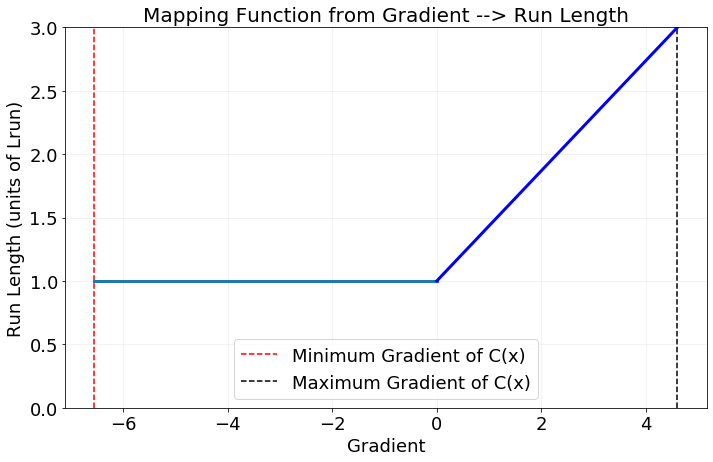

In [13]:
plt.figure(figsize = (11.5,7))
plt.title('Mapping Function from Gradient --> Run Length', fontsize = 20)
plt.ylim(0,3)
# plt.xlim(-8,8)
plt.ylabel('Run Length (units of Lrun)', fontsize = 18)
plt.xlabel('Gradient', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.axvline(deriv_array.min(), color = 'red', ls = '--', label = 'Minimum Gradient of C(x)')
plt.axvline(deriv_array.max(), color = 'black', ls = '--', label = 'Maximum Gradient of C(x)')

x = np.linspace(deriv_array.min(),0,50)
plt.plot(x, np.full(shape = len(x),fill_value = 1), lw = 3)

x2 = np.linspace(0,deriv_array.max(), 50)
y2 = (x2 / deriv_array.max()) * 2  + 1
plt.plot(x2,y2, color = 'blue', lw = 3)



plt.legend(fontsize = 18, loc = 'lower center')
plt.grid(alpha = .2)

This is an example of a Rectified Linear function (often used in neurons as activation functions for neural networks). This is an intuitive choice because you would imagine that the E. coli would never want to run more than the minimum amount possible (1 L_run in this scenario) if the gradient is negative --> therefore, negative gradients should map to L_run always. For positive gradients, I adopt a simple linear relationship between gradient and run length as shown above, with a minimum of L_run if the gradient is 0 and a maximum of 3* L_run if the gradient is ~4.2 (based on the concentration function's max gradient).

Now I create a function to run a simulation of fixed number of steps for a given E. coli, and store its positions at all times:

In [63]:
def runSim(x0, length, iterations):
    
    history = []
    e1 = ecoli(x0, length)
    counter = 0
    while counter < iterations:

        history.append(e1.position)
        v = e1.takeStep()
        counter = counter +1 
        
    return history

### Run a single test case:

Starting the ecoli at x = 2 with length = .2. 
Run for 10,000 steps.

In [64]:
xpositions = runSim(2,.2,10000)

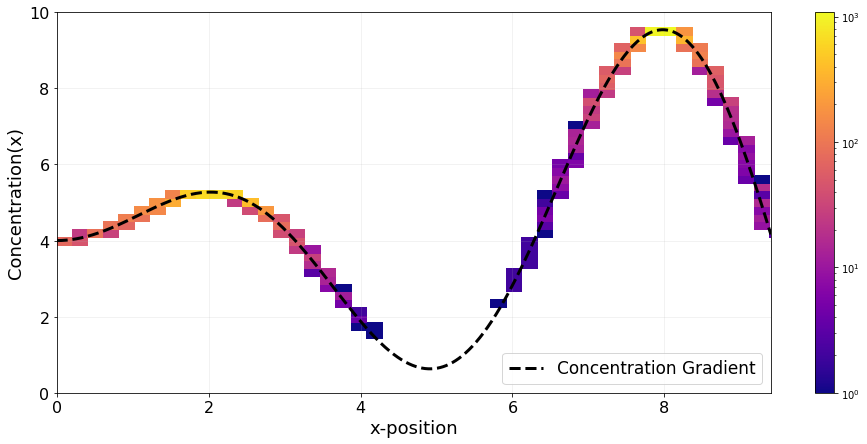

In [65]:
plt.figure(figsize = (16,7))
plt.plot(xnew, ynew, ls = '--', label = 'Concentration Gradient', color = 'black', lw = 3)
plt.xlabel('x-position',fontsize = 18)
plt.ylabel('Concentration(x)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.grid(alpha= .2)
f,x,y,i  = plt.hist2d(xpositions,spl(xpositions), bins = (np.linspace(0,10,50), np.linspace(0,10,50)), cmap = 'plasma', norm = LogNorm())
plt.legend(loc = 'lower right', fontsize = 17)
plt.colorbar()
plt.ylim(0,10)
plt.xlim(0,9.4)
plt.grid(alpha = .2)

Report some basic statistics about the E.coli's life:

In [66]:
topBinPercentage = f[39][46] / 10000 * 100
smallerPeakPercentage =  (f[9][25] + f[10][25]) / 10000 * 100

print('Bacterium spent %.2f percent of its time at the highest peak bin'%(topBinPercentage))
print('Bacterium spent %.2f percent of its time at the smaller peak top bins'%(smallerPeakPercentage))

Bacterium spent 10.83 percent of its time at the highest peak bin
Bacterium spent 13.48 percent of its time at the smaller peak top bins


### Notes on Visualization and "Data Collection" scheme
I am plotting the density of times that the E. coli has passed through a given location in log space. The locations are binned into bins approximately ~.204 "x units" across. This means that the bright yellow color corresponds to regions where the bacteria spent a significant amount of time. As the test case above shows, the bacteria released at x =2 spent the vast majority of its time at the two peaks. Later in this notebook, I will include a video of the ecoli moving around, but I figured that it would be hard to submit to Canvas so for now I use these static visuals. For the rest of the analysis, I use the binned number of steps spent near each of the peaks as a metric for how succesfull the chemotaxis is for the bacteria.

## 2b) iv. (actual answer)

The above was just a test case. Now I start the E. coli at various locations and see how it ends up. To get robust statistics, I run each bacterium for 1000 steps and start 20 bacteria at each starting spot. In all cases, I report the same two percentages as above, but then will average these to get a single report for eaching starting location. I hold the bacteria run length scale fixed across all trials.

In [108]:
def runAndReport(baclength = .2, numStepsPerBacteria = 1000,numBacteriaPerStartSpot = 20):
    
    ## initialize range of starting positions
    startingPositions = np.linspace(.1,9.3, 40)
    
    smallPercents = []
    tallPercents  = []
    
    
    for sp in startingPositions:
        small_per_start = []
        tall_per_start = []
        
        for i in range(numBacteriaPerStartSpot):
            xpositions = runSim(x0 = sp,length = baclength,iterations = numStepsPerBacteria)
            f,x,y,i  = plt.hist2d(xpositions,spl(xpositions), bins = (np.linspace(0,10,50), np.linspace(0,10,50)))
            plt.close()
            
            topBinPercentage = f[39][46] / numStepsPerBacteria * 100
            smallerPeakPercentage =  (f[9][25] + f[10][25]) / numStepsPerBacteria * 100
            small_per_start.append(smallerPeakPercentage)
            tall_per_start.append(topBinPercentage)
            del f,x,y,i
            
        ## report the mean percentages for each starting point    
        smallPercents.append(np.mean(small_per_start))
        tallPercents.append(np.mean(tall_per_start))
        
    return startingPositions,smallPercents,tallPercents

In [109]:
starts, small_peak_rates, tall_peak_rates = runAndReport()

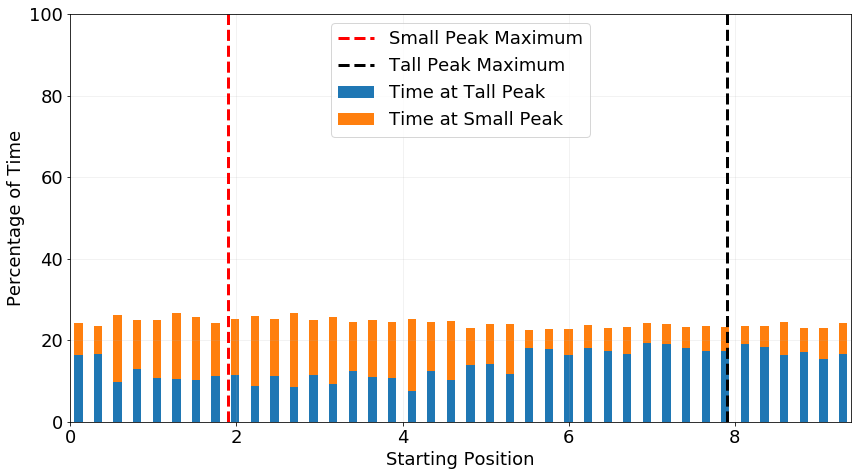

In [110]:
plt.figure(figsize = (14,7.5))
p1 = plt.bar(starts, tall_peak_rates, width = .1, label = 'Time at Tall Peak')
p2 = plt.bar(starts, small_peak_rates, width = .1,bottom= tall_peak_rates, label = 'Time at Small Peak')
plt.xlabel('Starting Position',fontsize = 18)
plt.xlim(0,9.4)
plt.ylim(0, 100)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.ylabel('Percentage of Time',fontsize = 18)
plt.axvline(1.9, color = 'red', lw = 3, ls = '--', label = 'Small Peak Maximum')
plt.axvline(7.9, color = 'black', lw = 3, ls = '--', label = 'Tall Peak Maximum')
plt.legend(fontsize = 18)
plt.grid(alpha = .2)

The above plot is the sum total of my findings for the bacteria's motion given the process I described above. I will summarize the most important interpretations from the above:

**1. The E.coli essentially always finds finds both peaks, irregardless of starting position.** The e.coli spend typically 23% of their time at either peak's top bin.

**2. If the E.coli starts near the lower peak, indicated by proximity to the red line, it will spend the plurality of its time there, but will still eventually find the tall peak, and will spend an appreciable about of time there (usually ~3/4 the time it spends at the small peak)**

**3. If the E.coli starts near the tall peak, it spend the plurality of its time there. Compared to the E.coli starting near the small peak, these E.coli have "less incentive" to move off the tall peak, and end up spending only a very small fraction of time near the smaller peak (less than the fraction of time those which started near the small peak spent near the top peak).** 

**4. The E. coli only spend ~20% of time in the optimal bin for either peak.** This is likely because the peaks are fairly narrow compared to their step size (and idea I explore in part v. below) and the degree of randomness in their steps forces them off the peak in essentially every step before they are restored to the ideal bin. In this regard, the maximum time they should spend at either peak is capped at 50 % (half on, half off before moving back), but in practical terms, the bacteria is much less efficient than that because if often will "lose the coinflip twice" and move away from the peak rather than restoring to the peak. Because of this, a rate of 20% at either peak is remarkably good!

**5. For this particular lengthscale, starting in a trough (eg , x= 5) does not particularly matter.** The bacteria can escape. One could imagine (or test, as I do below) that this might not necessarily hold for all bacteria length scales.


### Disclaimer: this analysis is based on when I ran the code. If you re-run, results might vary. They probably won't change significantly, since 1000 steps for each bacteria * 20 bacteria per starting spot is a pretty large sample size, but its possible that results do change irregardless.

## 2b) v. (actual answer)

The above analysis used run length significantly smaller than peak feature length -- I used run length of .2 and feature lengths are of order 3 for my concentration gradient. I consider feature length scale to be length from the top of either peak to the central trough. For the first smaller peak, that means peak size is [2,5] ~ 3 and for the taller peak, it is measured from [5,8] which is also size ~3.



Therefore, to get L_{run} /L_c = 0.01, I will change my bacterium length to be .3.

and


to get L_{run}/L_c = 0.5, I want my bacterium length to be 1.5.

I will now simply re-run the above scheme and plot the results for each:

In [130]:
starts, small_peak_rates, tall_peak_rates = runAndReport(baclength = .03)

Text(0.5, 1.0, 'Bacteria Length = .03')

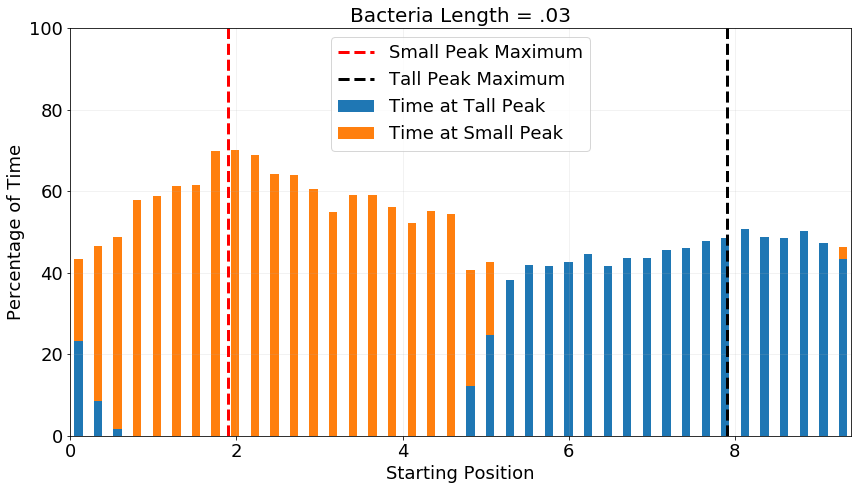

In [131]:
plt.figure(figsize = (14,7.5))
p1 = plt.bar(starts, tall_peak_rates, width = .1, label = 'Time at Tall Peak')
p2 = plt.bar(starts, small_peak_rates, width = .1,bottom= tall_peak_rates, label = 'Time at Small Peak')
plt.xlabel('Starting Position',fontsize = 18)
plt.xlim(0,9.4)
plt.ylim(0, 100)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.ylabel('Percentage of Time',fontsize = 18)
plt.axvline(1.9, color = 'red', lw = 3, ls = '--', label = 'Small Peak Maximum')
plt.axvline(7.9, color = 'black', lw = 3, ls = '--', label = 'Tall Peak Maximum')
plt.legend(fontsize = 18)
plt.grid(alpha = .2)
plt.title('Bacteria Length = .03', fontsize = 20)

In [126]:
starts, small_peak_rates, tall_peak_rates = runAndReport(baclength = 1.5)

Text(0.5, 1.0, 'Bacteria Length = 1.5')

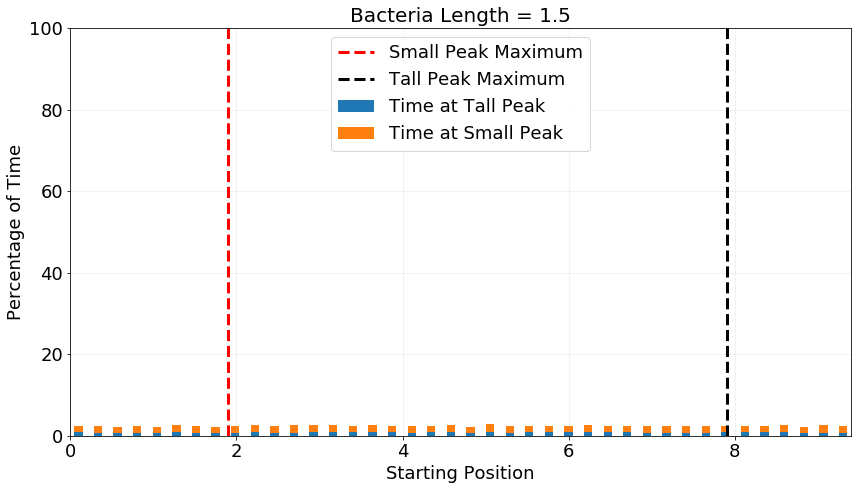

In [127]:
plt.figure(figsize = (14,7.5))
p1 = plt.bar(starts, tall_peak_rates, width = .1, label = 'Time at Tall Peak')
p2 = plt.bar(starts, small_peak_rates, width = .1,bottom= tall_peak_rates, label = 'Time at Small Peak')
plt.xlabel('Starting Position',fontsize = 18)
plt.xlim(0,9.4)
plt.ylim(0, 100)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.ylabel('Percentage of Time',fontsize = 18)
plt.axvline(1.9, color = 'red', lw = 3, ls = '--', label = 'Small Peak Maximum')
plt.axvline(7.9, color = 'black', lw = 3, ls = '--', label = 'Tall Peak Maximum')
plt.legend(fontsize = 18)
plt.grid(alpha = .2)
plt.title('Bacteria Length = 1.5', fontsize = 20)

## Preliminary Analysis:

**1. For length = .03, the bacteria spends 40-60 percent of its time in the top peak of either bin (compared to ~23% from length = .2). This suggests a dramatic improvement from the larger length. The bacteria essentially always chooses the closest peak. Presumably, a longer baseline in time would allow for greater exploration to find the other peaks as seen when length was .2, but still, would expect most bacteria spend most steps around the peak they started closest to.**

**2. For length = .03, starting position matters dramatically more than it did in the length = .2 case.**

**3. For length = 1.5, the bacteria spends less than 3% of its time at either peak -- substantially less than the shorter lengthscale bacteria do.** This is because it is dramatically easier to move off a peak and stay off, since even two "coin flips" pointing the bacteria away from a peak sending it far away from the peak itself into a regime where the gradient is typically much lower.

Text(0.5, 1.0, 'Bacteria Length = 1.5 (RESCALED Y AXIS)')

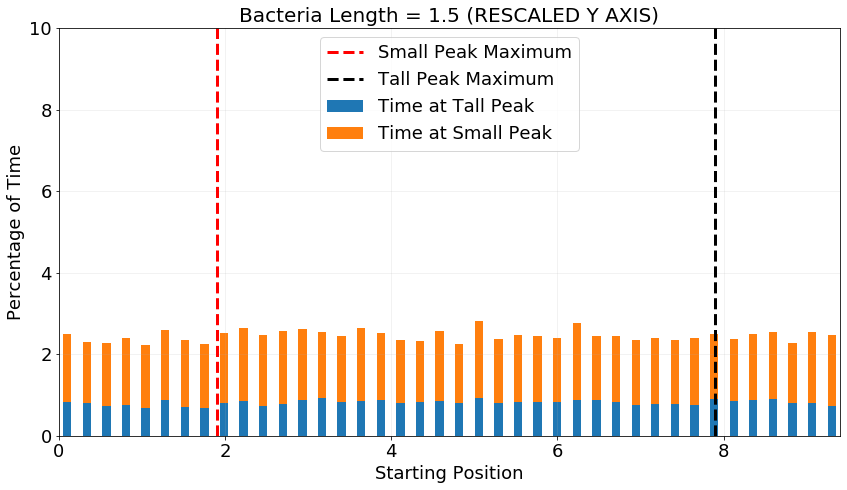

In [128]:
plt.figure(figsize = (14,7.5))
p1 = plt.bar(starts, tall_peak_rates, width = .1, label = 'Time at Tall Peak')
p2 = plt.bar(starts, small_peak_rates, width = .1,bottom= tall_peak_rates, label = 'Time at Small Peak')
plt.xlabel('Starting Position',fontsize = 18)
plt.xlim(0,9.4)
plt.ylim(0, 10)
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
plt.ylabel('Percentage of Time',fontsize = 18)
plt.axvline(1.9, color = 'red', lw = 3, ls = '--', label = 'Small Peak Maximum')
plt.axvline(7.9, color = 'black', lw = 3, ls = '--', label = 'Tall Peak Maximum')
plt.legend(fontsize = 18)
plt.grid(alpha = .2)
plt.title('Bacteria Length = 1.5 (RESCALED Y AXIS)', fontsize = 20)

### More analysis based on above plot.

**1. Since the length of each run ranges from [1.5,4.5], which is a huge region of the total bacteria's motion space, the motion is effectively random -- it almost does not matter that the peaks exist.** There are only 50 potential bins in my model, so peaks represent just 4 percent of the total space the bacteria can inhabit during a given step. This actually suggests that the probability of either peak is LESS than what it would be if the bacteria was randomly assigned a location in [0,10], which is a depressing result. 



**2. The plot above reveals that when the E.coli lengthscale is too large, it ALWAYS spends more time at the smaller peak. This is because the smaller peak is wider, and quite literally encompasses more of the probability space.**




## Final Conclusions for part 2b) v. :

**The run and tumble method is only optimized for low Reynolds number fluids, where bacteria's inertial control is low. Thus, when the bacteria has the ability to run huge distances (as in the second case above), the method is highly ineffective and can be worse than just random choice of runs.**

**Smaller run lengths are significantly more precise for the bacteria, and within reasonable limits, lead to more time spent at the peaks. This is why the run length of .01 * C(x) feature length works so well -- it rarely overshoots and falls off the peaks.**

# ------ End of Formal Assignment ---- #

# Bonus for fun: Animating the E. coli motions

In [117]:
starting_spots = 1 + .35 * np.arange(20)
ecoli_dish = [] 

for s_s in starting_spots:
    ecoli_dish.append(ecoli(s_s,.2))

In [118]:
fig = plt.figure(figsize = (12,6))
camera = Camera(fig)
history2 = []


plt.xlabel('x-position',fontsize = 18)
plt.ylabel('Concentration(x)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.grid(alpha= .2)
plt.title('E. coli Motion', fontsize = 20)
plt.ylim(0,10)
plt.xlim(0,9.4)


simlength = 100
e1 = ecoli(1.6, .2)
e2 = ecoli(5, .2)


for i in range(simlength):
    plt.plot(xnew, ynew, ls = '--', alpha = .75, label = 'Concentration Gradient', color = 'black', lw = 2.2)
    for e in ecoli_dish:
        e.takeStep()
        plt.scatter(x = e.position,y= float(spl(e.position)), s= 150)
  
    camera.snap()
anim = camera.animate(interval = 175, blit=True)
plt.close()

In [120]:
v = HTML(anim.to_html5_video())
v